### Proxy (To connect OpenAI in China)


In [9]:
import socket
import socks
socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 7890)
socks.set_default_proxy(socks.HTTP, "127.0.0.1", 7890)
socket.socket = socks.socksocket

### Configs

In [10]:
env_args = {
    "stock_name" : "AAPL",
    "start_date":"2014-01-01",
    "end_date":"2015-12-30"
}

In [11]:
from token_ import OPEN_AI_TOKEN
agent_args = {
    "model_name": "text-curie-001",
    "source": "local",
    "api_key": OPEN_AI_TOKEN
}

### Env

In [12]:
import gym
import json
import pandas as pd
from easydict import EasyDict as edict
from tqdm.notebook import tqdm

class Tweets_trading_env(gym.Env):
    def __init__(self,args):
        args = edict(args)
        self.stock_name = args.stock_name
        self.start_date = args.start_date
        self.end_date = args.end_date
        self.init_cash = args.init_cash if "init_cash" in args.keys() else 100
        self.init_hold = args.init_cash if "init_hold" in args.keys() else 100
        self.cal_on = args.cal_on if "cal_on" in args.keys() else "Close"
        
        self.read_file(args.stock_name)

    def read_file(self,stock_name):
        # sentences
        sentence_path = f"../../stocknet-dataset/tweet/preprocessed/{stock_name}/"
        self.tweets_df = pd.DataFrame()
        for date in tqdm(pd.date_range(self.start_date,self.end_date)):
            date = date.date().strftime("%Y-%m-%d")
            file_path = f"{sentence_path}/{date}"
            try:
                with open(file_path, "r") as f:
                    sentences = f.readlines()
                sentences_dict = [json.loads(i) for i in sentences]
                sentences = [" ".join(i["text"]) for i in sentences_dict]
                date = [date for i in sentences_dict]
                time_ = [pd.to_datetime(i["created_at"]).time() for i in sentences_dict]
                user_id_str = [i["user_id_str"] for i in sentences_dict]
                temp_df = pd.DataFrame([sentences,date,time_,user_id_str]).T
                # print(temp_df)
                self.tweets_df = pd.concat([self.tweets_df,temp_df])
            except:
                print(f"{date} is missing",end = " ")
        self.tweets_df.columns = ["text","date","time","user_id"]
        self.tweets_df = self.tweets_df.reset_index(drop= True)
        self.date_list = self.tweets_df.sort_values("date")["date"].unique().tolist()

        # Prices
        price_path = f"../../stocknet-dataset/price/raw/{stock_name}.csv"
        self.price_df = pd.read_csv(price_path)
        self.price_df = self.price_df[self.price_df.Date.isin(self.date_list)]
        self.price_df[self.cal_on] /= self.price_df.iloc[0][self.cal_on]
        self.date_list = self.price_df.sort_values("Date")["Date"].unique().tolist()

    def reset(self):
        self.day_index = 0
        self.today = self.date_list[self.day_index]
        self.today_sentences = self.tweets_df[self.tweets_df.date == self.today]
        self.today_price = self.price_df[self.price_df["Date"] == self.today]
        self.today_cash = self.init_cash
        self.today_hold = self.init_hold
        self.terminal = False
        self.asset_memory = [self.init_cash * self.today_price[self.cal_on].item() + self.today_cash]
        self.hold_memory = [self.init_hold]
        self.reward_momory = [0]
        self.action_memory = [0]

        return self.today_sentences.text.tolist()
    
    def update(self):
        if self.day_index >= len(self.date_list)-1:
            self.terminal = True
        else:
            self.day_index += 1
            self.today = self.date_list[self.day_index]
            self.today_sentences = self.tweets_df[self.tweets_df.date == self.today]
            self.today_price = self.price_df[self.price_df["Date"] == self.today]

    def step(self,action):
        last_price = self.today_price[self.cal_on].item()
        last_hold = self.today_hold
        last_cash = self.today_cash
        last_asset = last_price * last_hold + last_cash
        self.update()
        if self.terminal:
            print("all_done")
        else:
            next_price = self.today_price[self.cal_on].item()
            if action >0:
                self.today_hold += 100
                buy_cost = 100* next_price
                self.today_cash -= buy_cost
            
            elif action <0:
                self.today_hold -= 100
                sell_earn = 100* next_price
                self.today_cash -= sell_earn
            
            else:
                pass
                
            next_asset = self.today_hold * next_price +  self.today_cash   
            self.reward = next_asset - last_asset
            self.asset_memory.append(next_asset)
            self.hold_memory.append(self.today_hold)
            self.reward_momory.append(self.reward)
            self.action_memory.append(action)
        
        return self.today_sentences.text.tolist(), self.reward ,self.terminal ,{}
    

### GPT Agent

In [15]:
import openai
import numpy as np
import pickle
import time

class GPT_agent:
    def __init__(self,args):
        args = edict(args)
        self.model_name = args.model_name
        self.source = args.source
        if self.source == "openai":
            openai.api_key = args.api_key
        elif self.source == "local":
            with open("./data/sentiment_results.pkl","rb") as f:
                self.sentiment_dict = pickle.load(f)
   
    def __call__(self,obs:list):
        self.score_list = []
        for o in obs:
            self.score_list.append(self.get_sentiment(o))
        self.score_list_mean =  np.mean(self.score_list)
        if self.score_list_mean >0.3:
            return 1
        elif self.score_list_mean <-0.3:
            return -1
        else:
            return 0
    
    def get_sentiment(self,sentence):
        if self.source == "openai":
            time.sleep(1)
            response = openai.Completion.create(
                model = "text-curie-001",
                prompt = f"Decide whether a sentence's sentiment is positive, neutral, or negative.\n\nSentence: \"{sentence}\"\nSentiment: ",
                temperature=0,
                max_tokens=60,
                top_p=1,
                frequency_penalty=0.5,
                presence_penalty=0
                )
            response = response["choices"][0]["text"]
        elif self.source == "local":
            response = self.sentiment_dict[sentence]
            
        
        if "negative" in response:
            return -1
        elif "Negative" in response:
            return -1
        elif "positive" in response:
            return 1
        elif "Positive" in response:
            return 1
        else:
            return 0 

### Trade

In [16]:
env = Tweets_trading_env(env_args)
agent = GPT_agent(agent_args)
obs = env.reset()
terminal = False
while not terminal:
    # print(env.today)
    action = agent(obs)
    obs,reward,terminal,info = env.step(action)

  0%|          | 0/729 [00:00<?, ?it/s]

2014-01-17 is missing 2014-01-18 is missing 2014-06-17 is missing 2014-08-05 is missing 2014-08-06 is missing 2014-09-24 is missing 2014-09-25 is missing 2014-09-26 is missing 2014-09-27 is missing 2014-09-28 is missing 2014-11-10 is missing 2014-11-11 is missing 2014-11-12 is missing 2014-11-13 is missing 2014-11-15 is missing 2014-11-16 is missing 2014-11-17 is missing 2014-11-18 is missing 2014-11-19 is missing 2014-11-20 is missing 2014-11-21 is missing 2014-11-22 is missing 2014-11-23 is missing 2014-12-20 is missing 2015-03-08 is missing 2015-06-05 is missing 2015-06-23 is missing 2015-07-08 is missing 2015-08-15 is missing 2015-09-17 is missing 2015-09-18 is missing 2015-11-27 is missing 2015-12-16 is missing 2015-12-18 is missing all_done


### Plot

In [27]:
import matplotlib.pyplot as plt

<AxesSubplot:>

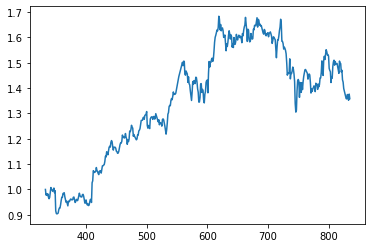

In [26]:
# stock price
env.price_df.Close.plot()

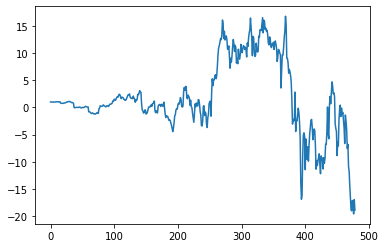

In [28]:
# assets
assets = env.asset_memory
assets = [i/assets[0] for i in assets]
plt.plot(assets)

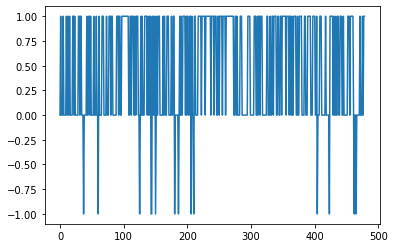

In [29]:
# actions
actions = env.action_memory
plt.plot(actions)

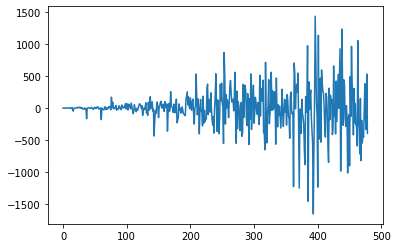

In [30]:
# rewards
rewards = env.reward_momory
plt.plot(rewards)